---
**License**

 MagDustBounce

 Mon Jun 01 09:20:00 2020\
 Copyright  2020\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 MagDustBounce\
 Copyright (C) 2020 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

# Magnetic field in dust dominated bouncing cosmology

In this notebook we develop the necessary objects to compute the power spectrum (and other observables) for magnetic field production in the contraction phase of a bouncing cosmology dominated by a dust-like fluid.

The scale factor for this model is given by:
\begin{equation}
\frac{a(t)}{a_0} = \frac{1}{x_b}\left[1 + \left(\frac{t}{t_b}\right)^2\right]^{1/3}, \quad x \equiv \frac{a_0}{a}, \quad x_b \equiv \frac{a_0}{a_b},
\end{equation}
where $a_b$ gives the value of the scale factor at the bounce ($t = 0$), and $t_b$ the bounce time-scale. Solving the time $t$ in terms of the scale factor and substituting back to the Hubble function we can relate the free parameter $t_b$ with the dimensionless density $\Omega_m$, i.e.,
\begin{equation}
H^2 = \left(\frac{\dot a}{a}\right)^2 = \frac{4}{9}\frac{x^3}{t_b^2x_b^3} - \frac{4}{9}\frac{x^6}{t_b^2x_b^6} = \frac{1}{R_H^2}\left(\Omega_m x^3 + \Omega_Q x^6\right) \quad\Rightarrow\quad t_b = \frac{2}{3}\frac{R_H}{\sqrt{\Omega_m x_b^3}}, \quad \Omega_Q = - \frac{\Omega_m}{x_b^3}.
\end{equation}
where $R_H \equiv 1/H_0$ is the Hubble radius today and $\Omega_m$ is the dimensionless matter density today.

From here on we will express everything in unit of the Hubble radius, $t \to t/R_H$ and $t_b \to t_b / R_H$.

The electromagnetic vector field satisfy the following Hamilton equations:
\begin{equation}
\dot{A} = \frac{\Pi_A}{m}, \qquad \dot{\Pi}_A = -m\nu^2 A, \qquad m \equiv a F,\quad \nu = \frac{k}{a},\qquad F \equiv \frac{1}{4}\left(1+l_*^2 R\right), \qquad R = 6\left[\frac{\ddot{a}}{a}+\left(\frac{\dot{a}}{a}\right)^2\right].
\end{equation}
for the mode $k$. It is convenient to rewrite $F$ as
\begin{equation}
F = \frac{1}{4}\left\{1+c_*^2\frac{\left(t/t_b\right)^2+3}{\left[\left(t/t_b\right)^2+1\right]^2}\right\}, \qquad c_* \equiv \frac{2}{\sqrt3}\frac{l_*}{t_b}.
\end{equation}


## Loading NumCosmo

The first step is to load both NumCosmo and NumCosmoMath libraries.

In [1]:
try:
    import gi

    gi.require_version("NumCosmo", "1.0")
    gi.require_version("NumCosmoMath", "1.0")
except:
    pass

import sys
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

# A helper function to write latex formatted numbers

In [2]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if base == 1.0:
            return r"10^{{{1}}}".format(int(exponent))
        else:
            return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

# Initializing the library

In [3]:
__name__ = "NcContext"

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

# Complex structure quantization object

Below we define our object as a child of the complex structure quantization object Ncm.CSQ1D

In [4]:
class PyCSQ1DMagDust(Ncm.CSQ1D):
    def __init__(self, Omega_m=0.3, xb=1.0e25, cc=1.0e-50, h=0.7, a_ns=1.0e-12):
        Ncm.CSQ1D.__init__(self)

        self.h = h
        self.Omega_m = Omega_m
        self.xb = xb
        self.tb = (2.0 / 3.0) * (1.0 / math.sqrt(Omega_m * xb**3))
        self.cc = cc
        self.RH = Ncm.C.c() / (1.0e5 * h)  # Hubble radius in units of Mpc
        self.a_ns = a_ns

    # Scale factor over scale factor today
    def y_t(self, t):
        tbar = t / self.tb
        tbar2 = tbar * tbar

        return np.cbrt(1.0 + tbar2) / self.xb

    def Omega_m_t(self, t):
        return self.Omega_m * self.y_t(t) ** (-3)

    def t_y(self, y):
        return self.tb * math.sqrt(
            (self.xb * y) ** 3 - 1.0 if (self.xb * y) ** 3 > 1.0 else 0.0
        )

    # The Hubble function
    def H_t(self, t):
        tbar = t / self.tb
        tbar2 = tbar * tbar

        return (2.0 / 3.0 * tbar / (1.0 + tbar2)) / self.tb

    # The function $F$ defined above
    def F_t(self, t):
        cc = self.cc
        cc2 = cc**2
        tbar = t / self.tb
        tbar2 = tbar * tbar

        return 0.25 * (1.0 + cc2 * (tbar2 + 3.0) / (tbar2 + 1.0) ** 2)

    def Fconst_time(self):
        cc = self.cc
        cc2 = cc**2
        tbar = math.sqrt(0.5 * (-2.0 + cc2 + cc * math.sqrt(8.0 + cc2)))
        return tbar * self.tb

    def set_max_c(self, f):
        w = self.a_ns * self.xb
        self.cc = math.sqrt(f) * w ** (3.0 / 2.0) / math.sqrt(1.0 + 2.0 / w**3)
        return self.cc

    def do_eval_xi(self, model, t, k):
        return math.log(k) + math.log(self.F_t(t))

    def do_eval_nu(self, model, t, k):
        return k / self.y_t(t)

    def do_eval_nu2(self, model, t, k):
        return (k / self.y_t(t)) ** 2

    def do_eval_m(self, model, t, k):
        return self.y_t(t) * self.F_t(t)

    def do_eval_F1(self, model, t, k):
        cc = self.cc
        cc2 = cc**2
        tbar = t / self.tb
        tbar2 = tbar * tbar
        tbar3 = tbar2 * tbar
        tbar4 = tbar2 * tbar2

        if tbar2 < 1.0:
            T1 = -2.0 * cc2 * tbar * (tbar2 + 5.0)
            T2 = tbar2 + 1.0
            T3 = T2**2
            T4 = cc2 * (tbar2 + 3.0)
            return (T1 / (T2 * (T3 + T4) * self.tb)) / (
                2.0 * self.do_eval_nu(model, t, k)
            )
        else:
            T1 = -2.0 * cc2 * tbar * (1.0 + 5.0 / tbar2)
            T2 = 1.0 + 1.0 / tbar2
            T3 = T2**2
            T4 = cc2 * (1.0 + 3.0 / tbar2)
            return (T1 / (T2 * (T3 + T4 / tbar2) * tbar4 * self.tb)) / (
                2.0 * self.do_eval_nu(model, t, k)
            )

    def do_eval_F2(self, model, t, k):
        cc = self.cc
        cc2 = cc**2
        tbar = t / self.tb
        tbar2 = tbar * tbar
        tbar4 = tbar2 * tbar2
        tbar6 = tbar4 * tbar2

        if tbar2 < 1.0:
            T1 = (2.0 / 3.0) * cc2 / self.tb**2
            T2 = cc2 * (-45.0 + 3.0 * tbar2 + 17.0 * tbar4 + tbar6)
            T3 = (1.0 + tbar2) ** 2
            T4 = -15.0 + 7.0 * tbar2 * (8.0 + tbar2)
            T5 = (T3 + cc2 * (3.0 + tbar2)) ** 2
            return (T1 * (T2 + T3 * T4) / (T3 * T5)) / (
                2.0 * self.do_eval_nu(model, t, k)
            ) ** 2
        else:
            T1 = (2.0 / 3.0) * cc2 / self.tb**2
            T2 = cc2 * (-45.0 / tbar6 + 3.0 / tbar4 + 17.0 / tbar2 + 1.0)
            T3 = (1.0 / tbar2 + 1.0) ** 2
            T4 = -15.0 / tbar4 + 7.0 * (8.0 / tbar2 + 1.0)
            T5 = (T3 + cc2 * (3.0 / tbar4 + 1.0 / tbar2)) ** 2
            return (T1 * (T2 / tbar2 + T3 * T4) / (T3 * T5 * tbar4)) / (
                2.0 * self.do_eval_nu(model, t, k)
            ) ** 2

    def do_prepare(self, model):
        pass

    def eval_PB_PE(self, t, c_A2=0.0, c_PiA2=0.0):
        if (c_A2 == 0.0) or (c_PiA2 == 0.0):
            (J11, J12, J22) = self.get_J_at(None, t)
        A2 = 0.5 * J11 if c_A2 == 0.0 else c_A2
        PiA2 = 0.5 * J22 if c_PiA2 == 0.0 else c_PiA2
        F = self.F_t(t)
        xb = self.xb
        k = self.get_k()
        y = self.y_t(t)
        RH = self.RH
        m = self.eval_m(None, t, k)
        PE = PiA2 * (k / y) ** 3 / (2.0 * math.pi**2 * RH**4 * m)
        PB = m * A2 * (k / y) ** 5 / (2.0 * math.pi**2 * RH**4)

        return PB, PE

In [5]:
csq1d = PyCSQ1DMagDust(cc=1.0e20, xb=1.0e30)

print("c = % 22.15g" % csq1d.set_max_c(1.0e-2))
csq1d.cc = 1.0e0

conv_rhoc = 5.0e-108
conv_g2 = 3.5e-115
t_F = csq1d.Fconst_time()
y_F = csq1d.y_t(t_F)

print("t_F % 22.15g y_F % 22.15g" % (t_F, y_F))

ki = 1.0
kf = 4.0e3
k_a = np.geomspace(ki, kf, 3)

csq1d.set_max_order_2(False)

csq1d.set_k(ki)
(Found2, tf) = csq1d.find_adiab_time_limit(None, +1.0e-25, +1.0e15, 1.0e0)
print(Found2, tf)

c =                  1e+26
t_F   1.21716123890037e-45 y_F   1.25992104989487e-30
True 1.9091882063630732


True -339.50686690065623
True -0.0013419816065257286
True -5.304765003755311e-09


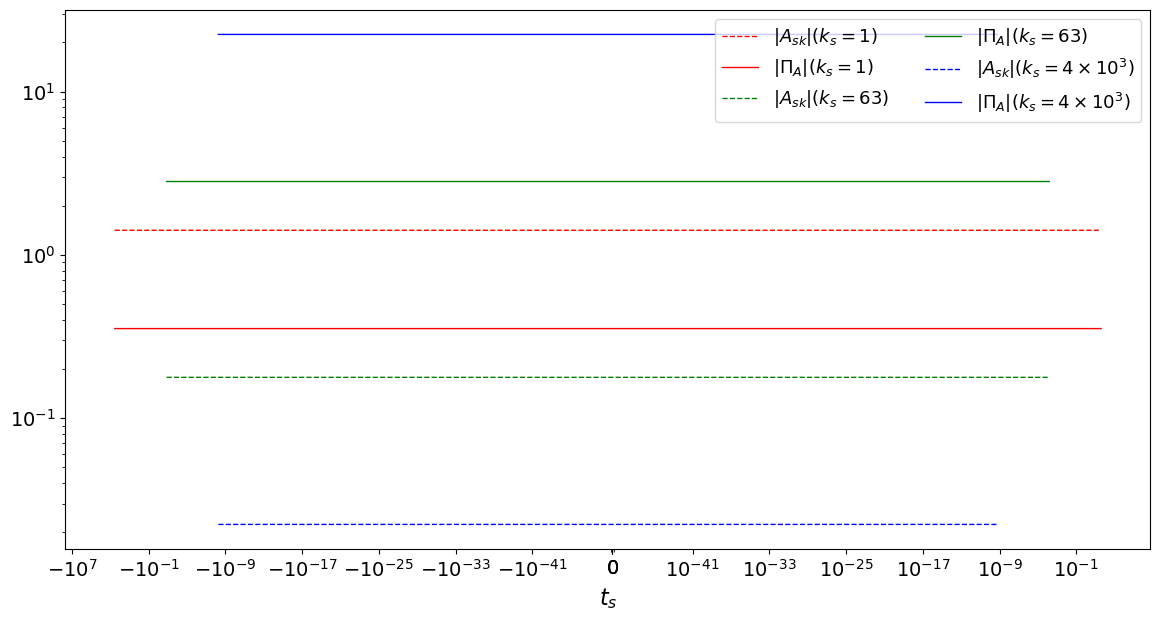

In [6]:
plt.figure(figsize=(14, 7))

max_tf = -1.0e300
min_ti = +1.0e300

colors = ["r", "g", "b"]
i = 0

for k in k_a:
    csq1d.set_k(k)
    csq1d.set_reltol(1.0e-12)
    csq1d.set_save_evol(True)

    # print (csq1d.eval_adiab_at (None, -5))

    (Found1, ti) = csq1d.find_adiab_time_limit(None, -1.0e15, -1.0e-25, 1.0e-3)
    print (Found1, ti)

    (Found2, tfa) = csq1d.find_adiab_time_limit(None, +1.0e-25, +1.0e15, 1.0e0)
    tf = tfa * 20

    min_ti = min(ti, min_ti)
    max_tf = max(tf, max_tf)

    csq1d.set_ti(ti)
    csq1d.set_tf(tf)
    csq1d.set_init_cond_adiab(None, ti)
    csq1d.prepare()

    t_a, t_s = csq1d.get_time_array()
    y_a = []
    Abs_phi2_a = []
    Abs_Pphi2_a = []

    t_a = np.array(t_a)

    for t in t_a:
        (J11, J12, J22) = csq1d.get_J_at(None, t)
        Abs_phi2_a.append(0.5 * J11)
        Abs_Pphi2_a.append(0.5 * J22)

    y_a = np.array(y_a)
    Abs_phi2_a = np.array(Abs_phi2_a)
    Abs_Pphi2_a = np.array(Abs_Pphi2_a)

    mylw = 1
    t_ar = t_a > tfa
    ampPhi = math.sqrt(max(Abs_phi2_a[t_ar]))
    ampPphi = math.sqrt(max(Abs_Pphi2_a[t_ar]))

    plt.plot(
        t_a,
        np.sqrt(Abs_phi2_a),
        lw=mylw,
        label=r"$|A_{sk}|(k_s = %s)$" % latex_float(k),
        linestyle="--",
        color=colors[i],
    )
    # plt.plot (t_a[t_ar], [ampPhi] * len (t_a[t_ar]),   lw=mylw, label = r'Amp of $\mathrm{Abs}(\phi)(k_s = %s)$' % latex_float (k), linestyle='--', color=colors[i])
    plt.plot(
        t_a,
        np.sqrt(Abs_Pphi2_a),
        lw=mylw,
        label=r"$|\Pi_A|(k_s = %s)$" % latex_float(k),
        color=colors[i],
    )
    # plt.plot (t_a[t_ar], [ampPphi] * len (t_a[t_ar]), lw=mylw, label = r'Amp of $\mathrm{Abs}(\Pi_\phi)(k_s = %s)$' % latex_float (k), color=colors[i])

    i = i + 1

tc_a = np.geomspace(min_ti, -t_s, 1000)
te_a = np.geomspace(t_s, max_tf, 1000)
t_a = np.concatenate((tc_a, te_a))

# plt.plot (t_a, [csq1d.y_t (t) for t in t_a], lw=mylw, label = r'$a(t)$')
# plt.plot (t_a, [csq1d.do_eval_F1 (None, t, k) for t in t_a], lw=mylw, label = r'$F_1(t)$')
# plt.plot (t_a, [csq1d.do_eval_m (None, t, k) for t in t_a], lw=mylw, label = r'$m(t)$')
# plt.plot (t_a, [csq1d.F_t (t) for t in t_a], lw=mylw, label = r'$F(t)$')

# plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend(loc="best", ncol=2, fontsize=13)
plt.xscale("symlog", linthresh=t_s)
plt.yscale("log")

plt.xlabel("$t_s$", fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)

# Erase overlapping ticks labels
ticks = plt.xticks()[0]
ticks[7] = 0
ticks[9] = 0
plt.xticks(ticks)

plt.savefig("MagDustModeEvol.pdf")
plt.show()

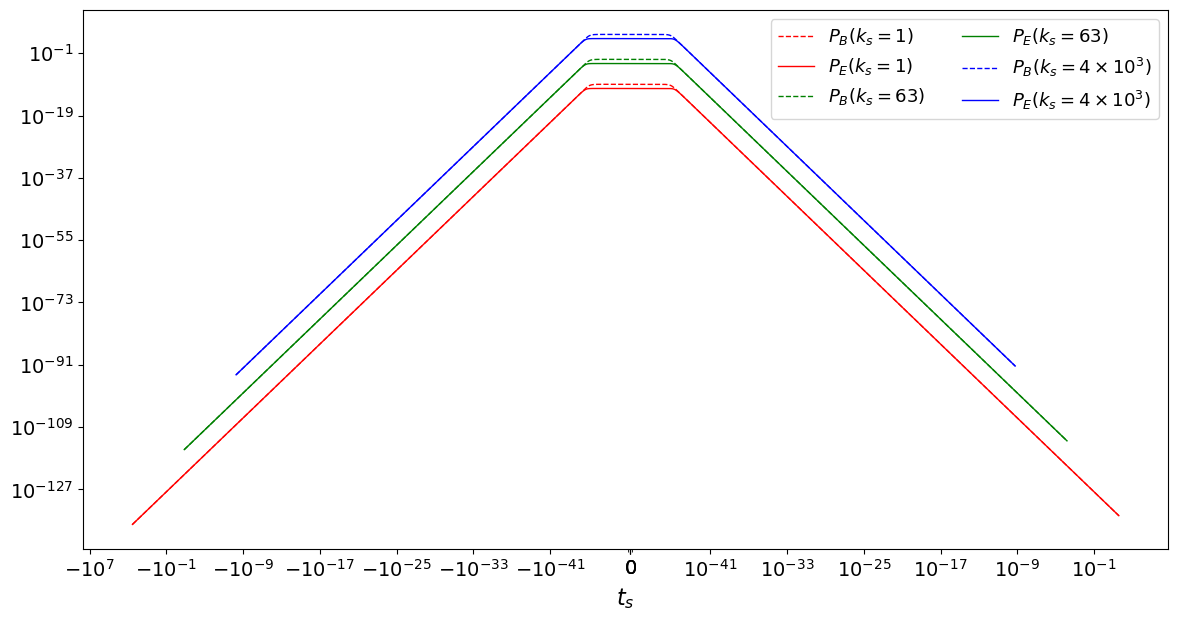

In [7]:
plt.figure(figsize=(14, 7))

max_tf = -1.0e300
min_ti = +1.0e300

colors = ["r", "g", "b", "r", "g", "b", "r", "g", "b", "r", "g", "b"]
i = 0

for k in k_a:
    csq1d.set_k(k)
    csq1d.set_reltol(1.0e-12)
    csq1d.set_save_evol(True)

    # print (csq1d.eval_adiab_at (None, -5))

    (Found1, ti) = csq1d.find_adiab_time_limit(None, -1.0e15, -1.0e-25, 1.0e-3)
    # print (Found1, ti)

    (Found2, tfa) = csq1d.find_adiab_time_limit(None, +1.0e-25, +1.0e15, 1.0e0)
    tf = tfa * 20

    min_ti = min(ti, min_ti)
    max_tf = max(tf, max_tf)

    csq1d.set_ti(ti)
    csq1d.set_tf(tf)
    csq1d.set_init_cond_adiab(None, ti)
    csq1d.prepare()

    t_a, t_s = csq1d.get_time_array()
    y_a = []
    PB_a = []
    PE_a = []

    t_a = np.array(t_a)

    for t in t_a:
        (PB, PE) = csq1d.eval_PB_PE(t)
        y_a.append(csq1d.y_t(t))
        PB_a.append(PB)
        PE_a.append(PE)

    y_a = np.array(y_a)
    PB_a = np.array(PB_a) * conv_g2
    PE_a = np.array(PE_a) * conv_g2

    mylw = 1

    plt.plot(
        t_a,
        PB_a,
        lw=mylw,
        label=r"$P_B(k_s = %s)$" % latex_float(k),
        linestyle="--",
        color=colors[i],
    )
    plt.plot(
        t_a, PE_a, lw=mylw, label=r"$P_E(k_s = %s)$" % latex_float(k), color=colors[i]
    )
    # plt.plot (t_a, PE_a+PB_a, lw=mylw, label = r'$P_B+P_E(k_s = %s)$' % latex_float (k),color=colors[i])
    # plt.plot (t_a, ((PE_a+PB_a)[-1]) * y_a[-1]**4 / y_a**4, lw=mylw, label = r'$\rho_r(k_s = %s)$' % latex_float (k))

    if i > 2:
        i = 0
    else:
        i = i + 1

tc_a = np.geomspace(min_ti, -t_s, 1000)
te_a = np.geomspace(t_s, max_tf, 1000)
t_a = np.concatenate((tc_a, te_a))

# plt.plot (t_a, [csq1d.y_t (t) for t in t_a], lw=mylw, label = r'$a(t)$')
# plt.plot (t_a, [csq1d.Omega_m_t (t) for t in t_a], lw=mylw, label = r'$\rho_m$')
# plt.axhline (y = 1.0)

# plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend(loc="best", ncol=2, fontsize=13)
plt.xscale("symlog", linthresh=t_s)
plt.yscale("log")

plt.xlabel("$t_s$", fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)

# Erase overlapping ticks labels
ticks = plt.xticks()[0]
ticks[7] = 0
ticks[9] = 0
plt.xticks(ticks)


plt.savefig("MagDustModeEvolPBPE.pdf")
plt.show()

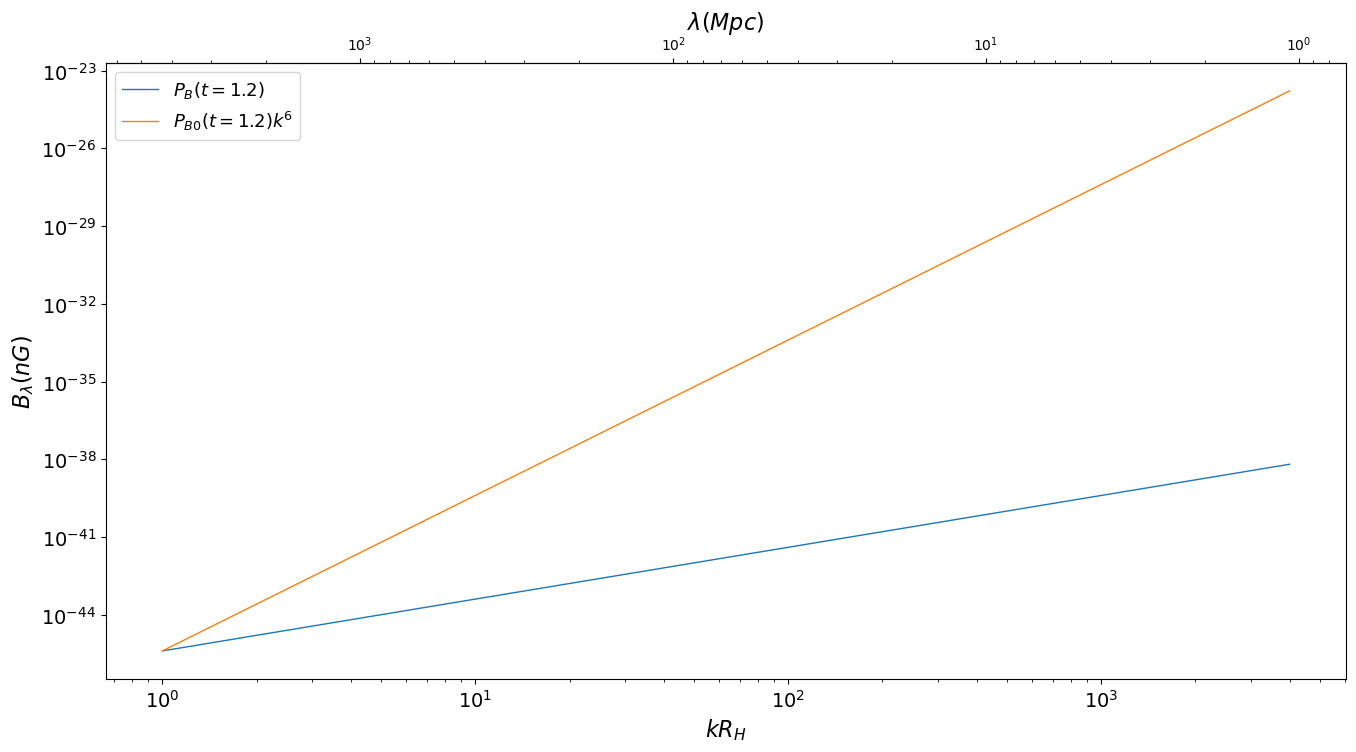

nE     =       3.99999999999481
nB     =       3.99999999999481
Ab[G2] =  5.270449442447432e-131
B1[nG] =  5.702848239406148e-46
Ab[rc] =  7.529213489210617e-124
kcut   =  6.036880750859433e+30
Or0    =  4.818696632893653e-110
x_eq   =  6.225749883321631e+108
t_eq   =  0.000000000000000e+00


In [8]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

k_a = np.geomspace(ki, kf, 10)
PB1_a = []
PE1_a = []
PB2_a = []
PE2_a = []

tf1 = 1.0e-35
tf2 = csq1d.t_y(1.0 / (1.0 + 0.0))

for k in k_a:
    csq1d.set_k(k)
    csq1d.set_reltol(1.0e-12)
    csq1d.set_save_evol(True)

    (Found1, ti) = csq1d.find_adiab_time_limit(None, -1.0e15, -1.0e-25, 1.0e-3)
    (Found2, tfa) = csq1d.find_adiab_time_limit(None, +1.0e-25, +1.0e15, 1.0e0)
    tf = tfa * 20

    csq1d.set_ti(ti)
    csq1d.set_tf(tf)
    csq1d.set_init_cond_adiab(None, ti)
    csq1d.prepare()

    t_a, t_s = csq1d.get_time_array()
    t_a = np.array(t_a)
    t_ra = t_a > tfa

    JM = np.array([np.array(csq1d.get_J_at(None, t)) * conv_g2 for t in t_a[t_ra]])
    phiAmp = 0.5 * max(JM[:, 0])
    PphiAmp = 0.5 * max(JM[:, 2])

    # (PE1, PB1) = csq1d.eval_PB_PE (tf1, c_A2 = phiAmp, c_PiA2 = PphiAmp)
    # PB1_a.append (PB1)
    # PE1_a.append (PE1)

    (PE2, PB2) = csq1d.eval_PB_PE(tf2, c_A2=phiAmp, c_PiA2=PphiAmp)
    PB2_a.append(PB2)
    PE2_a.append(PE2)

    # print (phiAmp, PphiAmp, PB2, PE2)

PE2_a = np.array(PE2_a)
PB2_a = np.array(PB2_a)

mylw = 1

# plt.plot (k_a, PE1_a,   lw=mylw, label = r'$P_E(%s)$' % latex_float (tf1))
# plt.plot (k_a, PB1_a,   lw=mylw, label = r'$P_B(%s)$' % latex_float (tf1))

# plt.plot (k_a, PE2_a,   lw=mylw, label = r'$P_E(%s)$' % latex_float (tf2))
# plt.plot (k_a, PB2_a,   lw=mylw, label = r'$P_B(%s)$' % latex_float (tf2))
# plt.plot (k_a, PB2_a[0] * (k_a / k_a[0] )**4,   lw=mylw, label = r'$P_{B0}(%s)k^4$' % latex_float (tf2))
# plt.plot (k_a, PB2_a[0] * (k_a / k_a[0] )**6,   lw=mylw, label = r'$P_{B0}(%s)k^6$' % latex_float (tf2))

plt.plot(
    k_a,
    np.sqrt(PB2_a * csq1d.RH**6) * 1.0e9,
    lw=mylw,
    label=r"$P_B(t = %s)$" % latex_float(tf2),
)
plt.plot(
    k_a,
    math.sqrt(PB2_a[0] * csq1d.RH**6) * (k_a / k_a[0]) ** 6 * 1.0e9,
    lw=mylw,
    label=r"$P_{B0}(t = %s)k^6$" % latex_float(tf2),
)

# plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend(loc="best", fontsize=13)

plt.xscale("log")
plt.yscale("log")

# Top x-axis


def forward(x):
    return [csq1d.RH / xi if xi > 0.0 else 1.0e30 for xi in x]


def inverse(x):
    return [csq1d.RH / xi if xi > 0.0 else 1.0e30 for xi in x]


ax2 = ax.secondary_xaxis("top", functions=(forward, inverse))
ax2.set_xlabel("$\lambda (Mpc)$", fontsize=16)

plt.xlabel("$k R_H$", fontsize=16)
plt.ylabel("$B_{\lambda} (nG)$", fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)


plt.savefig("MagDustPS.pdf")
plt.show()

nE = math.log(PE2_a[1] / PE2_a[0]) / math.log(k_a[1] / k_a[0])
nB = math.log(PB2_a[1] / PB2_a[0]) / math.log(k_a[1] / k_a[0])

Abg = (PE2_a[0] + PB2_a[0]) / k_a[0] ** nB
Abr = Abg / conv_g2 * conv_rhoc
Or0 = Abr * kf**nB / nB
xeq = csq1d.Omega_m / Or0
teq = csq1d.t_y(1.0 / xeq)

print("nE     = % 22.15g" % (nE))
print("nB     = % 22.15g" % (nB))
print("Ab[G2] = % 22.15e" % (Abg))
print("B1[nG] = % 22.15e" % (math.sqrt(Abg * csq1d.RH**6) * 1.0e9))
print("Ab[rc] = % 22.15e" % (Abr))
print("kcut   = % 22.15e" % ((1.0 / Abr) ** (1.0 / nB)))
print("Or0    = % 22.15e" % (Or0))
print("x_eq   = % 22.15e" % (xeq))
print("t_eq   = % 22.15e" % (teq))